In [ ]:
# Import the required libraries

import torch
import os
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data
from torchvision import transforms
from torch.nn.functional import interpolate
import torch.nn as nn
import math
import numpy as np
from natsort import natsorted
from PIL import Image
import random

In [ ]:
# Code to upload dataset to google colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

path_to_train = 'drive/MyDrive/coco/train2017.zip'
path_to_val = 'drive/MyDrive/coco/val2017.zip'
path_to_ann = 'drive/MyDrive/coco/ann2017.zip'
directory_to_extract_to = 'data/'

with zipfile.ZipFile(path_to_train, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

with zipfile.ZipFile(path_to_val, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

with zipfile.ZipFile(path_to_ann, 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [ ]:
class COCO(Dataset):
    def __init__(self, 
                 train = True,  
                 transform = None):
        
        self.transform = transform
        
        if train:
          image_dir = 'data/train2017'
          label_dir = 'data/annotations/panoptic_train2017'
        else:
          # validation
          image_dir = 'data/val2017'
          label_dir = 'data/annotations/panoptic_val2017'

        self.image_dir  = image_dir
        self.label_dir  = label_dir
        
        all_images = os.listdir(image_dir)
        self.all_images = natsorted(all_images)
        
    def __len__(self):
        return len(self.all_images)

    def __getitem__(self, idx):    
        
        convert_tensor = transforms.ToTensor()
        
        image = Image.open(f"{self.image_dir}/{self.all_images[idx][:-4]}.jpg").convert("RGB")
        image = convert_tensor(image)

        label = Image.open(f"{self.label_dir}/{self.all_images[idx][:-4]}.png").convert("RGB")
        label = convert_tensor(label)
        
        if self.transform != None:
            image = self.transform(image)
            label = self.transform(label)
        
        return image, label

    
# I have resized the images to 64x64 as this will make designing the model easier.
image_transforms = transforms.Compose([
    transforms.CenterCrop(640),
    transforms.Resize(128),
    transforms.Normalize(0.5,0.5)
])
        
train_dataset = COCO(train= True,  transform = image_transforms)
val_dataset   = COCO(train= False, transform = image_transforms)

batch_size = 16
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle=True)
val_loader   = DataLoader(dataset = val_dataset,   batch_size = batch_size, shuffle=True)

print(f'{len(train_dataset)} Items in Train dataset')
print(f'{len(val_dataset)} Items in Validation dataset')

118287 Items in Train dataset
5000 Items in Validation dataset


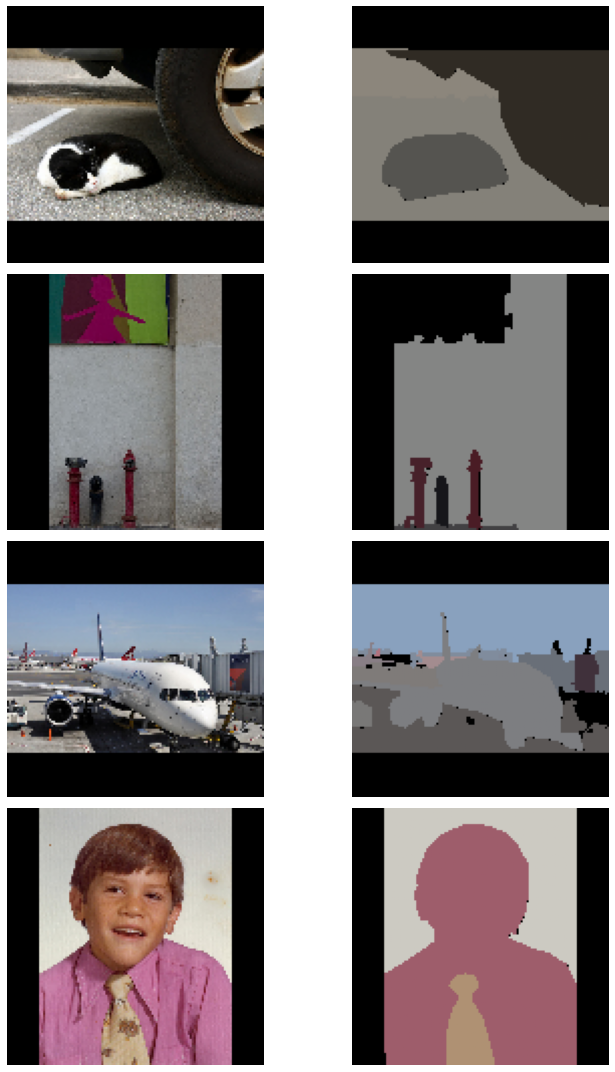

In [ ]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(15,15))
cols, rows = 3, 4
for i in range(rows):
    
    images, labels = next(iter(train_loader))
    
    # The image
    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[0].squeeze().permute(1, 2, 0) +1 )/2 )
    
    # The Label
    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((labels[0].squeeze().permute(1, 2, 0) +1 )/2)
    
plt.tight_layout()
plt.show()

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels,out_channels,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        )
    def forward(self, x):
        return self.main(x)
    
class Encoder(nn.Module):
    def __init__(self, channels=(3,128,256,512,1024)):
        super().__init__()
        self.encoding_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        )
        self.pool = nn.MaxPool2d(2)
    
    def forward(self, x):
        features = []
        
        for block in self.encoding_blocks:
            x = block(x)
            features.append(x)
            x = self.pool(x)
                 
        return features
        
class Decoder(nn.Module):
    def __init__(self, channels=(1024,512,256,128)):
        super().__init__()
        self.channels = channels
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(self.channels[i], self.channels[i+1],2,2) for i in range(len(channels)-1)])
        self.decoder_blocks = nn.ModuleList(
            [Block(channels[i], channels[i+1]) for i in range(len(channels)-1)]
        )
    
    def forward(self, x, encoder_features):
        for i in range(len(self.channels)-1):
            x = self.upconvs[i](x)
            features = self.crop(encoder_features[i], x)
            x = torch.cat([x, features], dim=1)
            x = self.decoder_blocks[i](x)
        return x
    
    def crop(self, features, x):
        _, _, height, width = x.shape
        features = transforms.CenterCrop([height, width])(features)
        return features
        
class UNet(nn.Module):
    def __init__(self, 
                 encode_channels=(3,128,256,512,1024), 
                 decode_channels=(1024,512,256,128), 
                 num_class=3, 
                 retain_dim=True, 
                 output_size=(572,572)):
        
        super(UNet, self).__init__()
        
        self.encoder = Encoder(encode_channels)
        self.decoder = Decoder(decode_channels)
        
        self.head = nn.Conv2d(decode_channels[-1], num_class, 1)
        
        """# Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)"""


    def forward(self, x):
        
        encoding_features = self.encoder(x)
        decoding_features = self.decoder(encoding_features[::-1][0], encoding_features[::-1][1:])
        output = self.head(decoding_features)

        output = torch.sigmoid(output)  # Range = [ 0, 1]
        output = torch.mul(output, 2)   # Range = [ 0, 2]
        output = torch.sub(output, 1)   # Range = [-1, 1]
        
        return output

model = UNet()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_params} Parameters in UNet')

images, _ = next(iter(train_loader))
output = model(images)
print(output.shape)

del model, output, images

30790787 Parameters in UNet
torch.Size([16, 3, 128, 128])


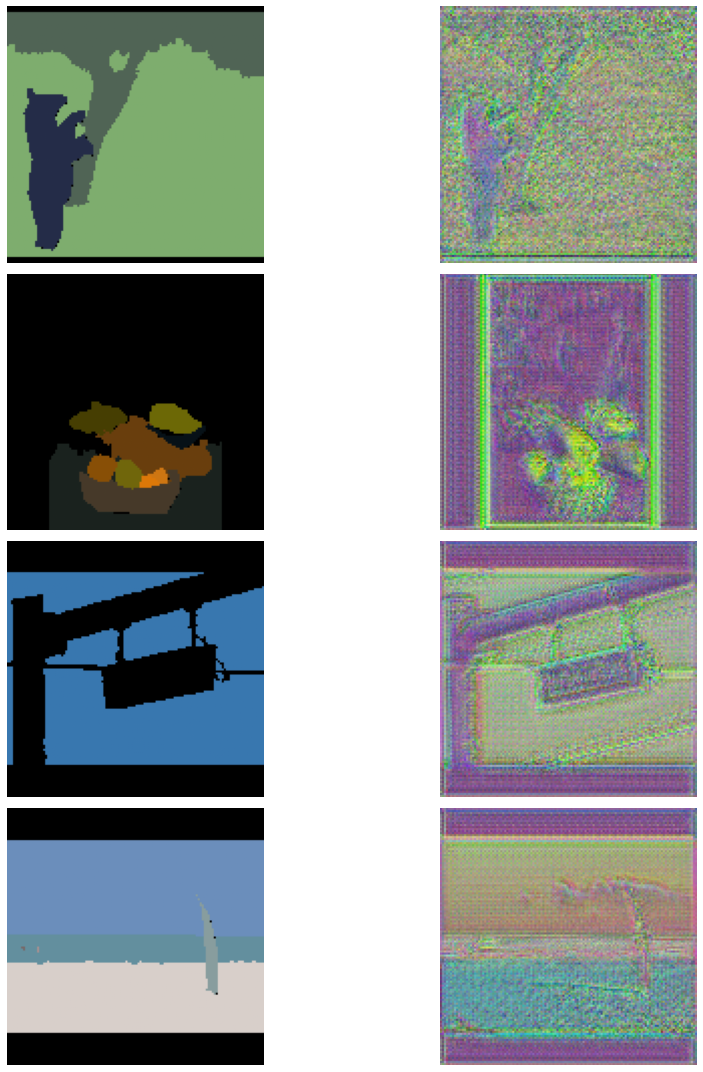

In [ ]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
model = UNet()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
images, labels, model = images.to(device), labels.to(device), model.to(device)

output = model(images)

figure = plt.figure(figsize=(15,15))
cols, rows = 2, 4
for i in range(rows):

    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((labels[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/ 2 )

    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((output[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/ 2 )  

plt.tight_layout()
plt.show()

del images, labels, model, output

In [ ]:
# Set up our training environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet()
model = model.to(device)

loss_func = nn.L1Loss()

optim = torch.optim.Adam(model.parameters(), lr=0.002)
num_epochs = 100

# These variables will store the data for analysis
training_losses = []
test_losses = []

In [ ]:
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
output = model(images)

loss = loss_func(output,labels)
print(loss)

tensor(0.6296, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
print('Starting Training')

for epoch in range(num_epochs):
    
    # Go into training mode
    model.train()
    
    # Train the model and evaluate on the training set
    total_train_loss = 0
    total_test_loss = 0

    for i, (images, labels) in enumerate(train_loader):
        
        # Move images to device and create an image prediction
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        
        loss = loss_func(output,labels)
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Record results
        total_train_loss += loss*images.shape[0]
        
        # Clear memory
        del images, labels, output
        torch.cuda.empty_cache()

    # Record training results
    total_train_loss /= len(train_dataset)
    training_losses.append(total_train_loss.item())

    # Evaluate the model on the test set
    model.eval()

    with torch.no_grad():
        for images, labels in val_loader:

            # Move images to device and create an image prediction
            images, labels = images.to(device), labels.to(device)
            output = model(images)

            # Evaluate the loss of our model         
            loss = loss_func(output,labels)
            
            # Record Results
            total_test_loss += loss*images.shape[0]

            del images, labels, output

        # Record test results
        total_test_loss /= len(val_dataset)

    # save counters
    test_losses.append(total_test_loss.item()) 
    
    print(f'Epoch [{epoch + 1}],Train Loss: {total_train_loss}, Val Loss: {total_test_loss}')

Starting Training


In [ ]:
plt.title("Training curve")

plt.plot(range(len(training_losses)),training_losses,'r')
plt.plot(range(len(test_losses)),test_losses,'g')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [ ]:
torch.save(model.state_dict(), 'weights-coco-1.pkl')

In [ ]:
!mv "/content/weights-coco-1.pkl" "/content/drive/My Drive/weights-coco-1.pkl" 

In [ ]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

output = model(images)

figure = plt.figure(figsize=(15,15))
cols, rows = 3, 5
for i in range(rows):
    figure.add_subplot(rows,cols, cols*i+1)
    plt.axis("off")
    plt.imshow((images[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/2 )

    figure.add_subplot(rows,cols, cols*i+2)
    plt.axis("off")
    plt.imshow((labels[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/2)

    figure.add_subplot(rows,cols, cols*i+3)
    plt.axis("off")
    plt.imshow((output[i].cpu().detach().squeeze().permute(1, 2, 0) +1 )/2)
    
plt.tight_layout()
plt.show()